# **생능 출판사 "으뜸 머신러닝"(1판) 교재의 소스 코드**
# *9장 합성곱 신경망*
---
* 출판사 : 생능 출판사( http://www.booksr.co.kr/ )
* 으뜸 파이썬 저자 : 강영민, 박동규, 김성수
*  소스코드 저장소 : https://github.com/dknife/ML
*  저작권 : 본 주피터 노트북 코드는 자유롭게 배포가능하지만 위의 출판사, 저서, 저자표기와 함께 배포해 주십시오.
---

### LAB 9-1 합성곱을 구현해 보자

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  8074  100  8074    0     0  21191      0 --:--:-- --:--:-- --:--:-- 21191


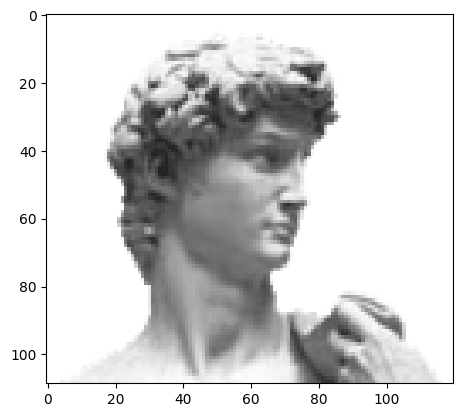

In [ ]:
# 이미지 다운로드
!curl -L 'https://github.com/dknife/ML/raw/main/data/image/david.png' > david.png
img = mpimg.imread('david.png')

plt.imshow(img)

In [ ]:
img.shape

(109, 120, 4)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  818k  100  818k    0     0  1341k      0 --:--:-- --:--:-- --:--:-- 6492k


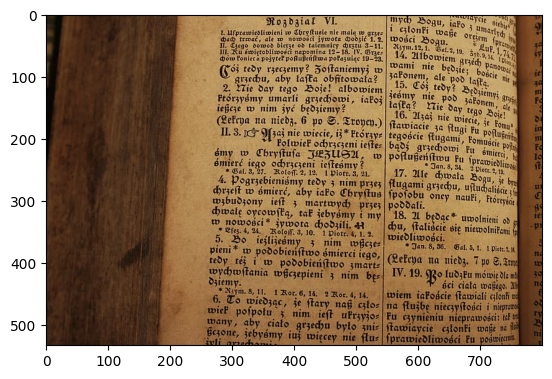

In [ ]:
# 이미지 다운로드
!curl -L 'https://github.com/dknife/ML/raw/main/data/image/book.png' > book.png
img = mpimg.imread('book.png')

plt.imshow(img)

In [ ]:
# 이미지 다운로드
!curl -L 'https://github.com/dknife/ML/raw/main/data/image/david.png' > david.png
img = mpimg.imread('david.png')

# 넘파이의 pad 함수를 이용한 패딩 구현
def padding(image, p_size):
    padded_img = np.pad(
                   array = image,
                   pad_width = ((p_size,p_size), (p_size,p_size), (0,0)),           # 순서대로 (상,하), (좌,우), (channel)에 대한 padding width를 지정
                   mode = 'constant', constant_values = 0)                          # constant mode : Pads with a constant value (이외에도 edge, mean, median, 등 다양한 mode가 존재)

    return padded_img

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  8074  100  8074    0     0  46402      0 --:--:-- --:--:-- --:--:-- 46402


(113, 124, 4)

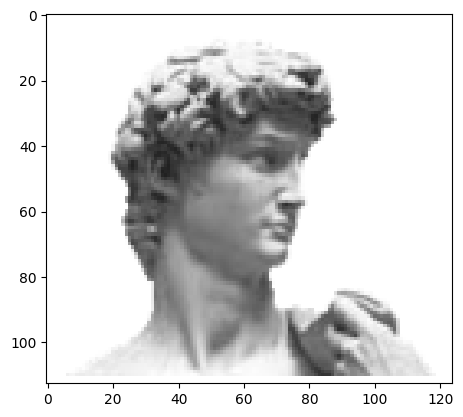

In [ ]:
padded = padding(img, 2)

plt.imshow(padded)
padded.shape

In [ ]:
# 1/9를 일괄적으로 적용하는 평균 필터 선언

box_filter = np.array(
   [[1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9]])

In [ ]:
def apply_filter(small_region, filter) :
    conv = np.multiply(small_region, filter)
    return np.sum(conv)

In [ ]:
# padding을 채우는 방식을 컨볼루션으로 하기 위한 선언

def convolution(img, filter):
   r, c, channels = img.shape
   rp, cp = filter.shape
   th_r, th_c = (rp-1)//2 , (cp-1)//2

   start = np.array([ th_r, th_c ])
   end = np.array([r, c]) - start
   print(start, end, rp, cp)
   conv_img = np.zeros( (r - th_r*2, c - th_c*2, channels) )

   for channel in range(channels):
       for i in range(start[0], end[0]):
           for j in range(start[1], end[1]):
               conv_img[i-th_r, j-th_c, channel] = apply_filter(img[i-th_r:i+th_r+1, j-th_c:j+th_c+1, channel], filter)

   return conv_img

[1 1] [112 123] 3 3


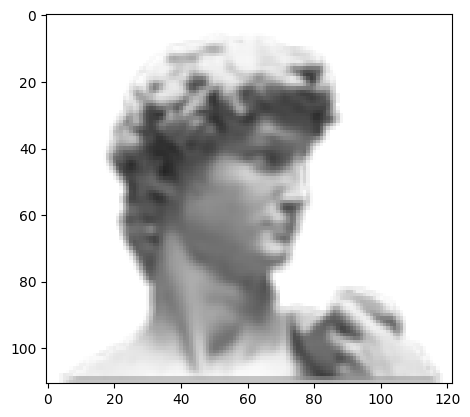

In [ ]:
conv_img = convolution(padded, box_filter)

plt.imshow(conv_img)

[1 1] [112 123] 3 3


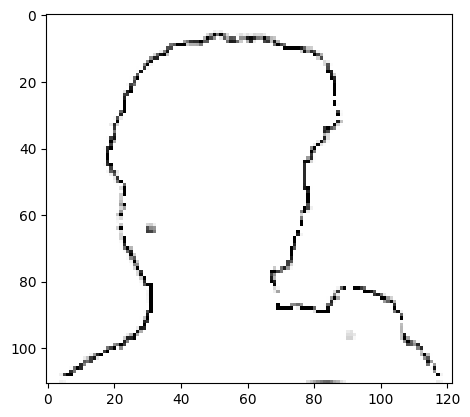

In [ ]:
# 라플라시안 필터 선언 (4방향)

laplacian = np.array(
                    [   [1, 0, 1],
                        [0, -4, 0],
                        [1, 0, 1],    ])
conv_img = convolution(padded, laplacian)

plt.imshow(conv_img)

[1 1] [112 123] 3 3


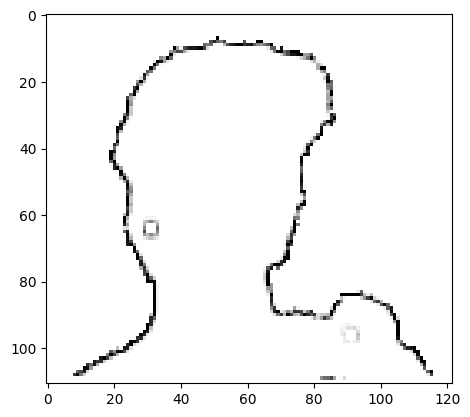

In [ ]:
# 라플라시안 필터 선언 (8방향)

laplacian_8dir = np.array(
                            [   [-1, -1, -1],
                                [-1, 8, -1],
                                [-1, -1, -1],    ])
conv_img_8dir = convolution(padded, laplacian_8dir)

plt.imshow(conv_img_8dir)

[1 1] [112 123] 3 3


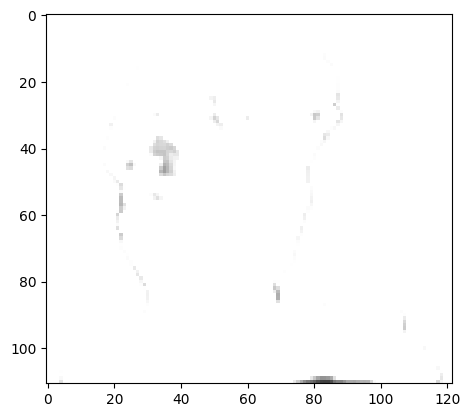

In [ ]:
unknown = np.random.rand(3, 3)

conv_img = convolution(padded, unknown)
np.clip(conv_img, 0, 255)                               # np.clip : array 내의 element들에 대해서 min 값 보다 작은 값들을 min값으로 바꿔주고 max 값 보다 큰 값들을 max값으로 바꿔주는 함수

plt.imshow(conv_img)

### 9-7 합성곱 신경망 모델의 구성

### LAB 9-2 : 합성곱 신경망으로 패션 MNIST 분류를 개선하기

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# 패션 MNIST 데이터는 keras의 데이터셋에 있으며, 이를 학습용, 테스트 데이터로 구분하자
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
print(train_images.shape)  # 학습 이미지의 형태와 레이블을 출력한다
print(train_labels)
print(test_images.shape)

(60000, 28, 28)
[9 0 0 ... 3 0 5]
(10000, 28, 28)


In [ ]:
# 합성곱 신경망은 (인스턴스 num, row, col, channel)으로 데이터를 제공해야하기에 변형한다

train_images = train_images[:, :, :, np.newaxis]
test_images = test_images[:, :, :, np.newaxis]

In [ ]:
model = keras.models.Sequential( [
    keras.layers.Conv2D(input_shape = (28, 28, 1), kernel_size = (3,3), padding = 'same', filters = 32),            # padding valid option : padding 적용하지 않음
                                                                                                                    # padding same option : padding 적용하여 출력 사이즈와 입력 사이즈가 동일하게 맞춤
    keras.layers.MaxPooling2D((2, 2), strides=2),                                                                   # strides : 필터가 이동하는 단위 (필터가 2x2 크기이고 strides를 2로 setting하면
                                                                                                                    #                                 pooling의 결과물이 원본보다 절반의 크기를 가지게 된다)
    keras.layers.Conv2D(kernel_size = (3,3), padding ='same', filters = 64),
    keras.layers.MaxPooling2D((2, 2), strides=2),
    keras.layers.Conv2D(kernel_size = (3,3), padding = 'same', filters = 32),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax'),
])

In [ ]:
model.summary()                         # Param # : 도출되는 파라미터 수 (아래의 경우 3x3 필터를 filters에 입력한 파라미터 수만큼 적용함)
                                        # 첫번째 conv를 경우로 보면 3x3(필터)x1(학습할 입력수)x32(필터수) + 32(output에 대한 bias) = 320
                                        # 두번째 conv를 경우로 보면 3x3(필터)x32(학습할 입력수)x64(필터수) + 64(output에 대한 bias) = 18496
                                        # 세번째 conv를 경우로 보면 3x3(필터)x64(학습할 입력수)x32(필터수) + 32(output에 대한 bias) = 18464

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          18464     
                                                                 
 flatten (Flatten)           (None, 1568)              0

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=5, validation_split=0.25)

Epoch 1/5
1407/1407 [==============================] - 23s 5ms/step - loss: 0.9004 - accuracy: 0.7351 - val_loss: 0.4365 - val_accuracy: 0.8479
Epoch 2/5
1407/1407 [==============================] - 10s 7ms/step - loss: 0.3721 - accuracy: 0.8702 - val_loss: 0.3358 - val_accuracy: 0.8820
Epoch 3/5
1407/1407 [==============================] - 9s 6ms/step - loss: 0.3050 - accuracy: 0.8897 - val_loss: 0.3687 - val_accuracy: 0.8726
Epoch 4/5
1407/1407 [==============================] - 7s 5ms/step - loss: 0.2939 - accuracy: 0.8947 - val_loss: 0.3590 - val_accuracy: 0.8849
Epoch 5/5
1407/1407 [==============================] - 8s 5ms/step - loss: 0.2760 - accuracy: 0.9023 - val_loss: 0.3204 - val_accuracy: 0.8888


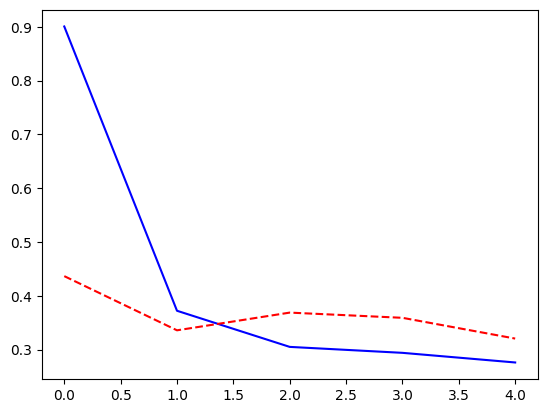

In [ ]:
plt.plot(history.history['loss'], 'b-')
plt.plot(history.history['val_loss'], 'r--')

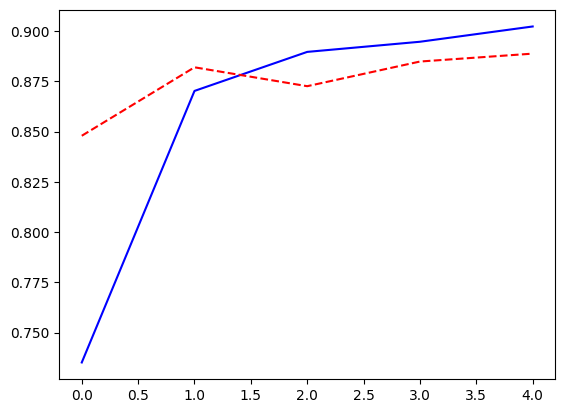

In [ ]:
plt.plot(history.history['accuracy'], 'b-')
plt.plot(history.history['val_accuracy'], 'r--')

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('테스트 정확도:', test_acc)

313/313 - 1s - loss: 0.3316 - accuracy: 0.8882 - 1s/epoch - 5ms/step
테스트 정확도: 0.8881999850273132


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
randIdx = np.random.randint(0, 1000)

images = test_images[randIdx:randIdx+25]
predictions = np.argmax(model.predict(images), axis=1)

print(predictions)

1/1 [==============================] - 0s 373ms/step
[0 7 0 4 4 5 2 9 5 9 3 7 5 7 8 1 0 0 6 6 8 9 7 9 1]


In [ ]:
def plot_images(images, labels, images_per_row=5):
 n_images = len(images)
 n_rows = (n_images-1) // images_per_row + 1
 fig, ax = plt.subplots(n_rows, images_per_row,
                        figsize = (images_per_row * 2, n_rows * 2))
 for i in range(n_rows):
     for j in range(images_per_row):
         if i*images_per_row + j >= n_images: break
         img_idx = i*images_per_row + j
         a_image = images[img_idx].reshape(28,28)
         if n_rows>1: axis = ax[i, j]
         else: axis = ax[j]
         axis.get_xaxis().set_visible(False)
         axis.get_yaxis().set_visible(False)
         label = class_names[labels[img_idx]]
         axis.set_title(label)
         axis.imshow(a_image, cmap='gray', interpolation='nearest')

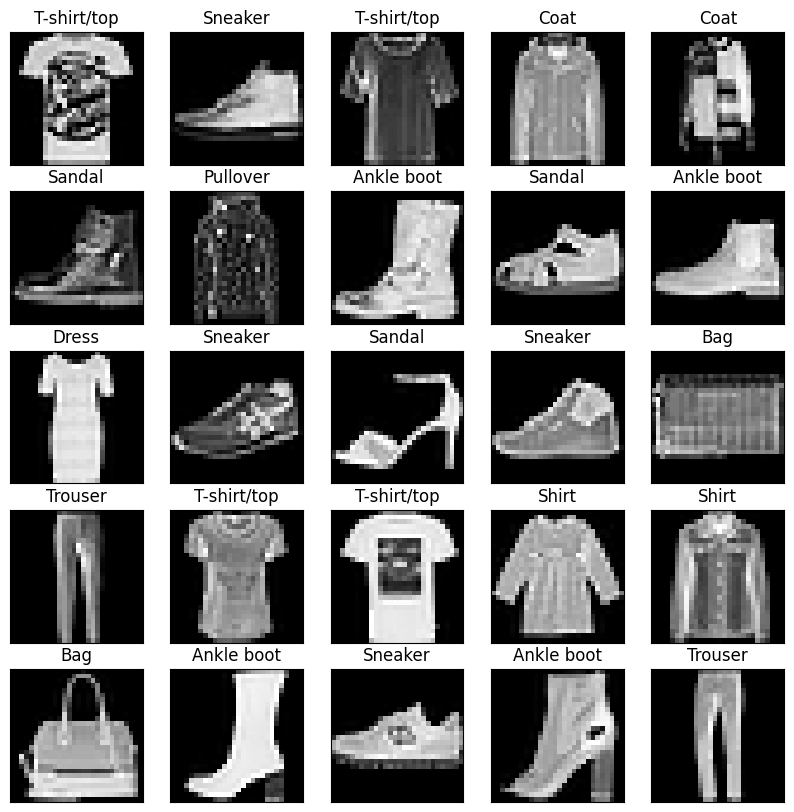

In [ ]:
plot_images(images, predictions, images_per_row = 5)

1/1 [==============================] - 0s 38ms/step


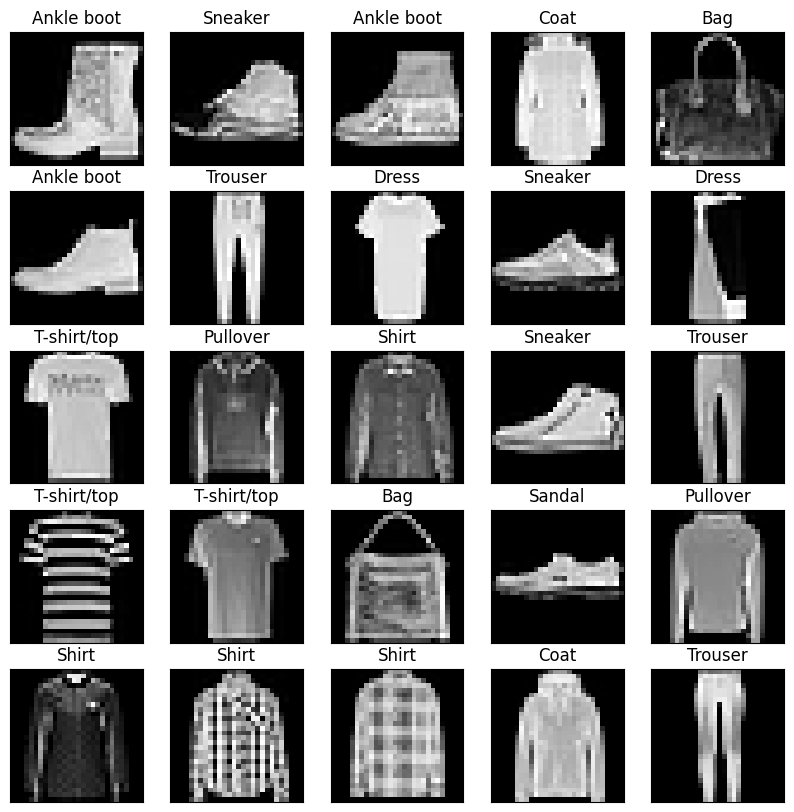

In [ ]:
randIdx = np.random.randint(0, 1000)

images = test_images[randIdx:randIdx+25]
predictions = np.argmax(model.predict(images), axis=1)
plot_images(images, predictions, images_per_row = 5)

### LAB 9-3: 고급 CNN을 가져다 써보자.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from keras.applications.inception_v3 import preprocess_input            # pre-training (사전 학습) : 포괄적인 데이터에 대해서 미리 학습해두는 과정
                                                                        # fine-tuning : 사전 학습 정보 중에서 세부적인 분야 학습에 도움이 되는 파트를 가져와 효율적으로 학습하는 과정
from keras.applications.inception_v3 import InceptionV3
from keras import models, layers
from keras.models import Model, load_model
import pandas as pd
from keras.optimizers import RMSprop

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 훈련데이터는 10000개, 검증 데이터는 2000개만 사용
x_train, x_test = x_train[:10000] / 255.0, x_test[:2000] / 255.0
y_train, y_test = y_train[:10000], y_test[:2000]

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train_preprocess = np.zeros((x_train.shape[0], 75, 75, 3), dtype=np.float32)
print(x_train_preprocess.shape)

# 훈련 데이터 각각의 크기를 75x75로 변형 (기존 데이터는 28x28 크기를 가지지만 ImageNet을 활용하려면 인셉션 모델이 최소 75x75 크기를 가져야 함)
for i, img in enumerate(x_train):
    img_resize = resize(img, (75, 75), anti_aliasing=True)
    x_train_preprocess[i] = np.dstack([img_resize, img_resize, img_resize])

(10000, 75, 75, 3)


In [ ]:
x_test_preprocess = np.zeros((x_test.shape[0], 75, 75, 3), dtype=np.float32)
print(x_test_preprocess.shape)

# 검증 데이터 각각의 크기를 75x75로 변형 (기존 데이터는 28x28 크기를 가지지만 ImageNet을 활용하려면 인셉션 모델이 최소 75x75 크기를 가져야 함)
for i, img in enumerate(x_test):
    img_resize = resize(img, (75, 75), anti_aliasing=True)
    x_test_preprocess[i] = np.dstack([img_resize, img_resize, img_resize])

(2000, 75, 75, 3)


In [ ]:
pre_trained_model = InceptionV3(input_shape=(75, 75, 3),
                              include_top=False,                # include_top : 가장 상단의 fully connected계층들을 포함 시킬지 말지에 대한 여부
                              weights=None)                     # 모델은 가져오지만 가중치는 가져오지 않음 (즉, 모델의 학습은 새롭게 진행하는 것)

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d_3[0][0]']               
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)                # 가중치가 형성되지 않았기 때문에 MLP에 더 많은 계층을 전달해주어야 한다
x = layers.Dense(10, activation='sigmoid')(x)

In [ ]:
model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.001),                  # ρ가 작을 수록 가장 최신의 기울기를 더 크게 반영한다
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model.fit(x_train_preprocess, y_train, epochs=20, validation_data=(x_test_preprocess, y_test))

Epoch 1/20
313/313 [==============================] - 28s 54ms/step - loss: 1.3487 - accuracy: 0.7576 - val_loss: 2.3804 - val_accuracy: 0.6330
Epoch 2/20
313/313 [==============================] - 14s 44ms/step - loss: 0.2861 - accuracy: 0.9379 - val_loss: 1.2133 - val_accuracy: 0.7965
Epoch 3/20
313/313 [==============================] - 14s 45ms/step - loss: 0.2130 - accuracy: 0.9548 - val_loss: 3.4725 - val_accuracy: 0.7795
Epoch 4/20
313/313 [==============================] - 14s 43ms/step - loss: 0.1590 - accuracy: 0.9664 - val_loss: 0.8448 - val_accuracy: 0.9140
Epoch 5/20
313/313 [==============================] - 14s 45ms/step - loss: 0.1317 - accuracy: 0.9743 - val_loss: 0.2274 - val_accuracy: 0.9695
Epoch 6/20
313/313 [==============================] - 15s 49ms/step - loss: 0.1182 - accuracy: 0.9765 - val_loss: 0.3550 - val_accuracy: 0.9440
Epoch 7/20
313/313 [==============================] - 20s 63ms/step - loss: 0.1081 - accuracy: 0.9797 - val_loss: 51.0055 - val_accuracy

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

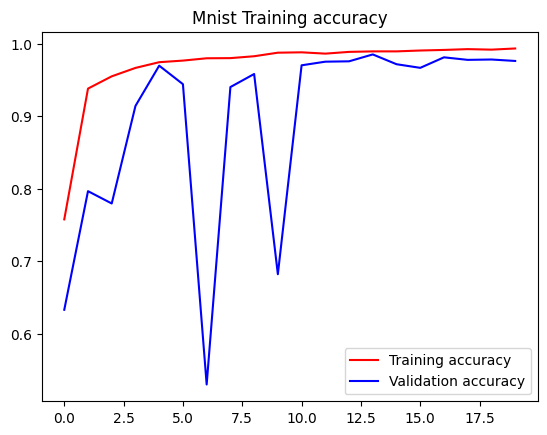

<Figure size 640x480 with 0 Axes>

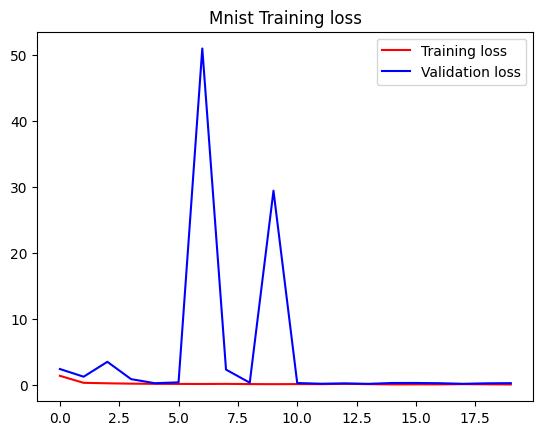

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title("Mnist Training accuracy")
plt.legend(loc=0)
plt.figure()
plt.show()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Mnist Training loss")
plt.legend(loc=0)
plt.figure()
plt.show()

### 9.9 전이학습 - 이미 훈련된 모델을 고쳐 쓰기링

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras import models, layers
from keras.models import Model, load_model
import pandas as pd
from keras.optimizers import RMSprop

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train[:10000] / 255.0, x_test[:2000] / 255.0
y_train, y_test = y_train[:10000], y_test[:2000]

x_train_preprocess = np.zeros((x_train.shape[0], 75, 75, 3),
                              dtype=np.float32)
print(x_train_preprocess.shape)

for i, img in enumerate(x_train):
    img_resize = resize(img, (75, 75), anti_aliasing=True)
    x_train_preprocess[i] = np.dstack([img_resize, img_resize, img_resize])

x_test_preprocess = np.zeros((x_test.shape[0], 75, 75, 3),
                             dtype=np.float32)
print(x_test_preprocess.shape)

# 검증 데이터 각각의 크기를 75x75로 변형 (인셉션모델 최소 입력 크기)
for i, img in enumerate(x_test):
    img_resize = resize(img, (75, 75), anti_aliasing=True)
    x_test_preprocess[i] = np.dstack([img_resize, img_resize, img_resize])

(10000, 75, 75, 3)
(2000, 75, 75, 3)


In [ ]:
# 사전 훈련된 모델을 가져온다. - 이미지넷 데이터로 학습된 모델
pre_trained_model = InceptionV3(input_shape=(75, 75, 3),
                              include_top=False,
                              weights='imagenet')                            # imagenet에서 사용하는 가중치를 해당 모델에도 적용

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# pre-training되어 있는 model에 대해서는 추가로 학습을 진행하지않고 해당 model의 가중치를 그대로 사용
for layer in pre_trained_model.layers:
    layer.trainable = False

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(10, activation='softmax')(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer=RMSprop(lr=0.0005),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_97 (Conv2D)             (None, 37, 37, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 37, 37, 32)  96          ['conv2d_97[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_94 (Activation)     (None, 37, 37, 32)   0           ['batch_normalization_94[0]

In [ ]:
history = model.fit(x_train_preprocess, y_train, epochs=20, validation_data=(x_test_preprocess, y_test))

Epoch 1/20
313/313 [==============================] - 16s 28ms/step - loss: 0.2974 - accuracy: 0.9151 - val_loss: 0.1591 - val_accuracy: 0.9480
Epoch 2/20
313/313 [==============================] - 6s 19ms/step - loss: 0.0840 - accuracy: 0.9746 - val_loss: 0.0939 - val_accuracy: 0.9705
Epoch 3/20
313/313 [==============================] - 5s 17ms/step - loss: 0.0549 - accuracy: 0.9832 - val_loss: 0.1049 - val_accuracy: 0.9715
Epoch 4/20
313/313 [==============================] - 6s 18ms/step - loss: 0.0397 - accuracy: 0.9872 - val_loss: 0.1080 - val_accuracy: 0.9685
Epoch 5/20
313/313 [==============================] - 5s 15ms/step - loss: 0.0295 - accuracy: 0.9906 - val_loss: 0.0727 - val_accuracy: 0.9765
Epoch 6/20
313/313 [==============================] - 6s 19ms/step - loss: 0.0229 - accuracy: 0.9932 - val_loss: 0.0757 - val_accuracy: 0.9775
Epoch 7/20
313/313 [==============================] - 5s 15ms/step - loss: 0.0169 - accuracy: 0.9954 - val_loss: 0.0688 - val_accuracy: 0.977

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

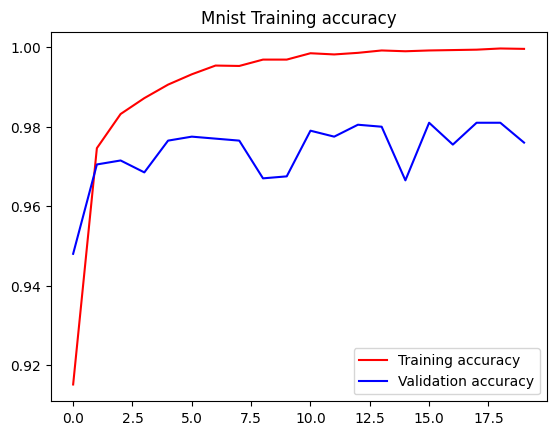

<Figure size 640x480 with 0 Axes>

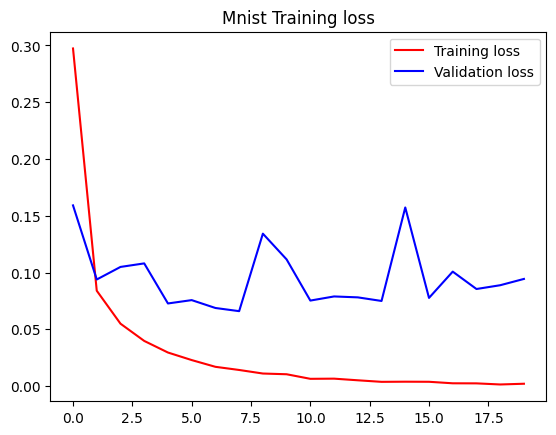

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title("Mnist Training accuracy")
plt.legend(loc=0)
plt.figure()
plt.show()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Mnist Training loss")
plt.legend(loc=0)
plt.figure()
plt.show()

### 9장 미니 프로젝트 B2  얼굴 찾기 : CNN 활용하기


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread             # 이미지를 읽어 들인다
from skimage.transform import resize      # 이미지의 크기를 변경할 수 있다

In [ ]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/faces/'

face_images = []

for i in range(15):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (64,64))
    face_images.append(img)

<Figure size 640x480 with 0 Axes>

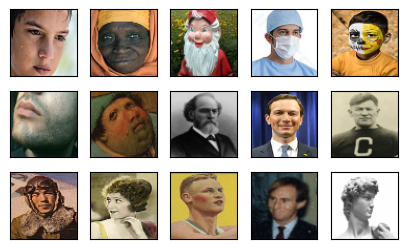

In [ ]:
def plot_images(nRow, nCol, img):
    fig = plt.figure()
    fig, ax = plt.subplots(nRow, nCol, figsize = (nCol,nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis = ax[i, j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol+j])

plot_images(3,5, face_images)

<Figure size 640x480 with 0 Axes>

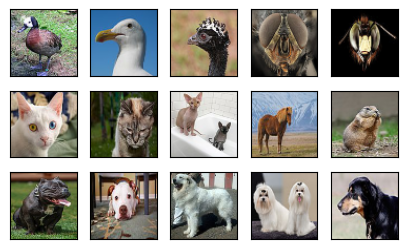

In [ ]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/animals/'

animal_images = []

for i in range(15):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (64,64))
    animal_images.append(img)

plot_images(3,5, animal_images)

In [ ]:
X =face_images + animal_images
y = [ [1,0] ]* len(face_images) + [ [0,1]] * len(animal_images)
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(30, 64, 64, 3) (30, 2)


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

model = keras.models.Sequential( [
    keras.layers.Conv2D(input_shape = (64, 64, 3),
                        kernel_size = (3,3), filters = 32),
    keras.layers.MaxPooling2D((2, 2), strides=2),
    keras.layers.Conv2D(kernel_size = (3,3), filters = 32),
    keras.layers.MaxPooling2D((2, 2), strides=2),
    keras.layers.Conv2D(kernel_size = (3,3), filters = 32),
    keras.layers.MaxPooling2D((2, 2), strides=2),
    keras.layers.Conv2D(kernel_size = (3,3), filters = 32),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dense(2, activation = 'softmax'),
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, epochs = 100)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.8706 - accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 14ms/step - loss: 0.6807 - accuracy: 0.5333
Epoch 3/100
1/1 [==============================] - 0s 20ms/step - loss: 0.6546 - accuracy: 0.6667
Epoch 4/100
1/1 [==============================] - 0s 14ms/step - loss: 0.6599 - accuracy: 0.5333
Epoch 5/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6228 - accuracy: 0.7333
Epoch 6/100
1/1 [==============================] - 0s 13ms/step - loss: 0.5798 - accuracy: 0.8333
Epoch 7/100
1/1 [==============================] - 0s 13ms/step - loss: 0.5569 - accuracy: 0.7333
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss: 0.5021 - accuracy: 0.9333
Epoch 9/100
1/1 [==============================] - 0s 14ms/step - loss: 0.4750 - accuracy: 0.9333
Epoch 10/100
1/1 [==============================] - 0s 19ms/step - loss: 0.4506 - accuracy: 0.7667
Epoch 11/100
1/1 [===

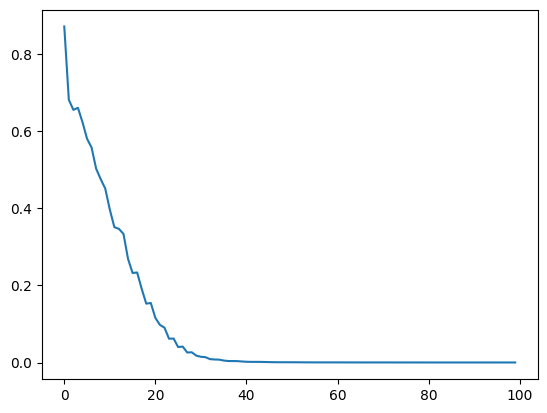

In [ ]:
plt.plot(history.history['loss'])

<Figure size 640x480 with 0 Axes>

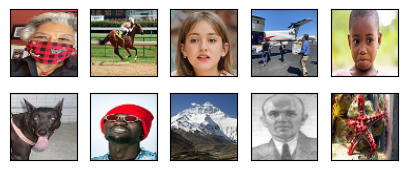

In [ ]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/test_data/'

test_images = []

for i in range(10):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (64,64))
    test_images.append(img)

test_images = np.array(test_images)
plot_images(2, 5, test_images)

1/1 [==============================] - 0s 231ms/step


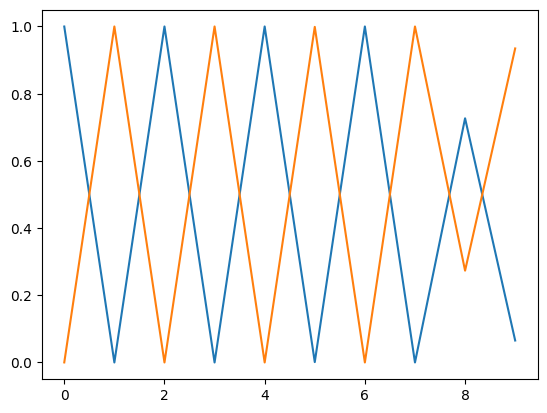

In [ ]:
test_result = model.predict(test_images)
plt.plot(test_result)

<Figure size 640x480 with 0 Axes>

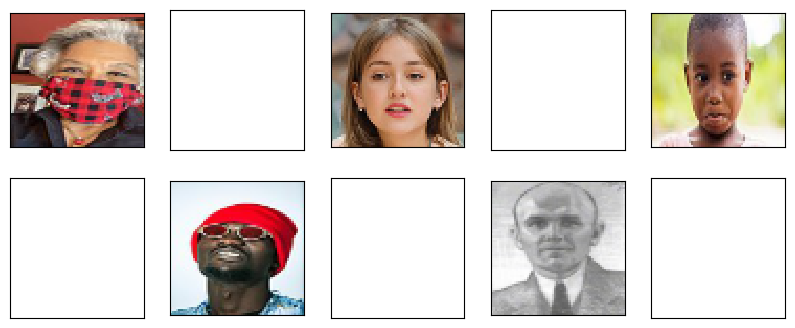

In [ ]:
fig = plt.figure()
fig, ax = plt.subplots(2,5, figsize = (10,4))
for i in range(2):
    for j in range(5):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        if test_result[i*5+j][0] > 0.5:
            ax[i, j].imshow(test_images[i*5+j],interpolation='nearest')

1/1 [==============================] - 0s 31ms/step


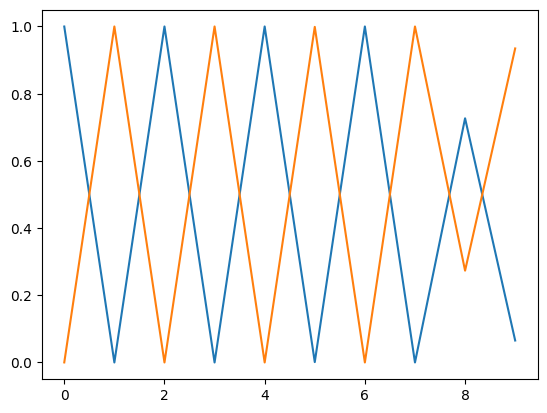

In [ ]:
test_result = model.predict(test_images)
plt.plot(test_result)

### 9장 미니 프로젝트 B3  얼굴 찾기 : 전이학습 활용하기


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread             # 이미지를 읽어 들인다
from skimage.transform import resize      # 이미지의 크기를 변경할 수 있다

In [ ]:
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras import models, layers
from keras.models import Model

In [ ]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/faces/'

<Figure size 640x480 with 0 Axes>

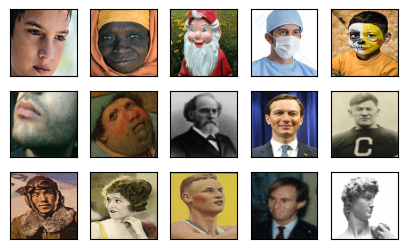

In [ ]:
face_images = []
for i in range(15):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (75,75))
    face_images.append(img)

def plot_images(nRow, nCol, img):
    fig = plt.figure()
    fig, ax = plt.subplots(nRow, nCol, figsize = (nCol,nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis = ax[i, j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol+j])

plot_images(3,5, face_images)

<Figure size 640x480 with 0 Axes>

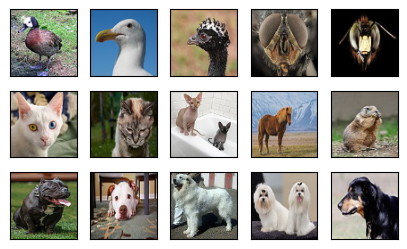

In [ ]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/animals/'

animal_images = []
for i in range(15):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (75,75))
    animal_images.append(img)

plot_images(3,5, animal_images)

In [ ]:
X = face_images + animal_images
# 얼굴 이미지는 1, 얼굴이 아닌 이미지는 0 - sparse_categorical_entropy
y = [[1]]* len(face_images) + [[0]] * len(animal_images)
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(30, 75, 75, 3) (30, 1)


In [ ]:
pre_trained_model = InceptionV3(input_shape=(75, 75, 3),
                                include_top=False,
                                weights=None)

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_195 (Conv2D)            (None, 37, 37, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 37, 37, 32)  96          ['conv2d_195[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_188 (Activation)    (None, 37, 37, 32)   0           ['batch_normalization_

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

my_layer = layers.Flatten()(last_output)
my_layer = layers.Dense(256, activation='relu')(my_layer)
my_layer = layers.Dense(256, activation='relu')(my_layer)
my_layer = layers.Dense(1, activation='sigmoid')(my_layer)

In [ ]:
model = Model(pre_trained_model.input, my_layer)

model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_195 (Conv2D)            (None, 37, 37, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 37, 37, 32)  96          ['conv2d_195[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_188 (Activation)    (None, 37, 37, 32)   0           ['batch_normalization_188[0

In [ ]:
history = model.fit(X, y, epochs=100, shuffle=True)

Epoch 1/100
1/1 [==============================] - 39s 39s/step - loss: 0.2752 - accuracy: 0.3667
Epoch 2/100
1/1 [==============================] - 0s 73ms/step - loss: 0.1744 - accuracy: 0.7000
Epoch 3/100
1/1 [==============================] - 0s 75ms/step - loss: 0.4984 - accuracy: 0.5000
Epoch 4/100
1/1 [==============================] - 0s 163ms/step - loss: 0.5000 - accuracy: 0.5000
Epoch 5/100
1/1 [==============================] - 0s 127ms/step - loss: 0.5000 - accuracy: 0.5000
Epoch 6/100
1/1 [==============================] - 0s 99ms/step - loss: 0.5000 - accuracy: 0.5000
Epoch 7/100
1/1 [==============================] - 0s 100ms/step - loss: 0.5000 - accuracy: 0.5000
Epoch 8/100
1/1 [==============================] - 0s 116ms/step - loss: 0.5000 - accuracy: 0.5000
Epoch 9/100
1/1 [==============================] - 0s 97ms/step - loss: 0.5000 - accuracy: 0.5000
Epoch 10/100
1/1 [==============================] - 0s 100ms/step - loss: 0.5000 - accuracy: 0.5000
Epoch 11/100
1

1/1 [==============================] - 2s 2s/step


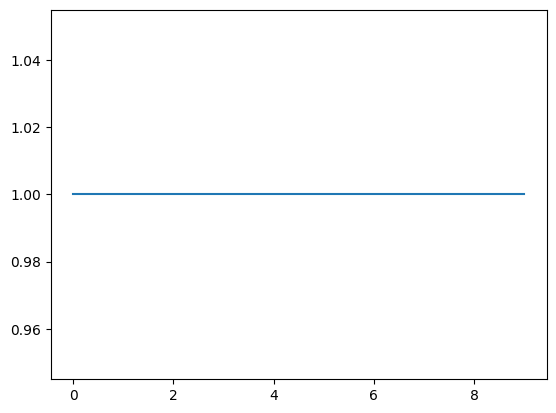

<Figure size 640x480 with 0 Axes>

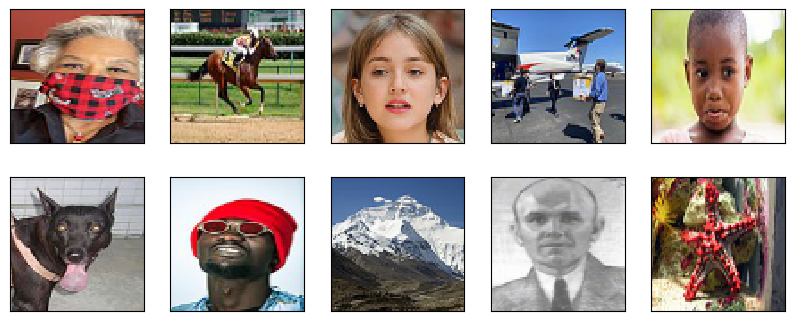

In [ ]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/test_data/'

test_images = []
for i in range(10):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (75,75))
    test_images.append(img)

test_images = np.array(test_images)
test_result = model.predict(test_images)
plt.plot(test_result)

fig = plt.figure()
fig, ax = plt.subplots(2,5, figsize = (10,4))
for i in range(2):
    for j in range(5):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        if test_result[i*5+j] > 0.5:
            ax[i, j].imshow(test_images[i*5+j],interpolation='nearest')

In [ ]:
frozen = InceptionV3(input_shape=(75, 75, 3),
                     include_top=False,
                     weights='imagenet')
last_layer = frozen.get_layer('mixed7')
last_output = last_layer.output

for layer in frozen.layers:
    layer.trainable = False

In [ ]:
my_layer = layers.Flatten()(last_output)
my_layer = layers.Dense(256, activation='relu')(my_layer)
my_layer = layers.Dense(256, activation='relu')(my_layer)
my_layer = layers.Dense(1, activation='sigmoid')(my_layer)

transfer_learner = Model(frozen.input, my_layer)
transfer_learner.summary()
transfer_learner.compile(optimizer='adam',
            loss='mse',
            metrics=['accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_289 (Conv2D)            (None, 37, 37, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 37, 37, 32)  96          ['conv2d_289[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_282 (Activation)    (None, 37, 37, 32)   0           ['batch_normalization_282[0

In [ ]:
history = transfer_learner.fit(X, y, epochs=100, shuffle=True)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.3462 - accuracy: 0.4667
Epoch 2/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0748 - accuracy: 0.9333
Epoch 3/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 26ms/step - loss: 4.3358e-04 - accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 26ms/step - loss: 1.2322e-04 - accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 31ms/step - loss: 3.4236e-05 - accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 0s 27ms/step - loss: 1.1931e-05 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 0s 26ms/step - loss: 4.8981e-06 - accuracy: 1.0000
E

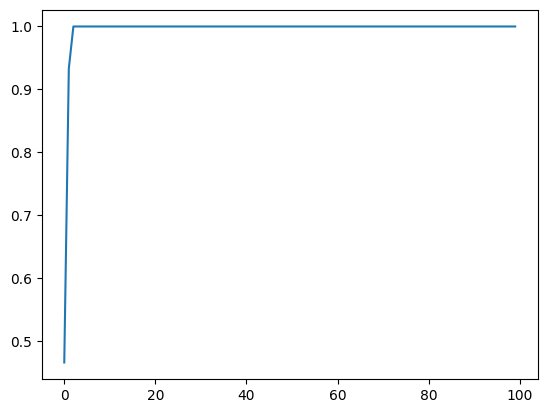

In [ ]:
plt.plot(history.history['accuracy'])

1/1 [==============================] - 1s 904ms/step


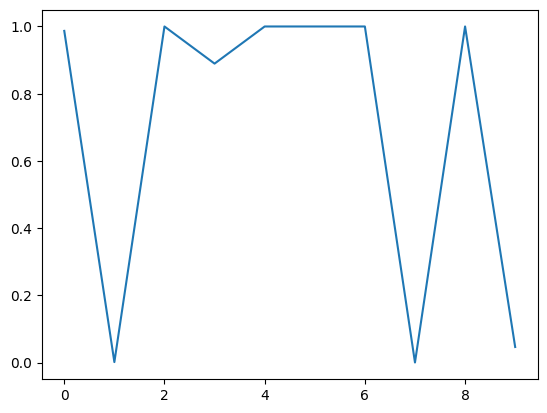

In [ ]:
test_result = transfer_learner.predict(test_images)
plt.plot(test_result)

<Figure size 640x480 with 0 Axes>

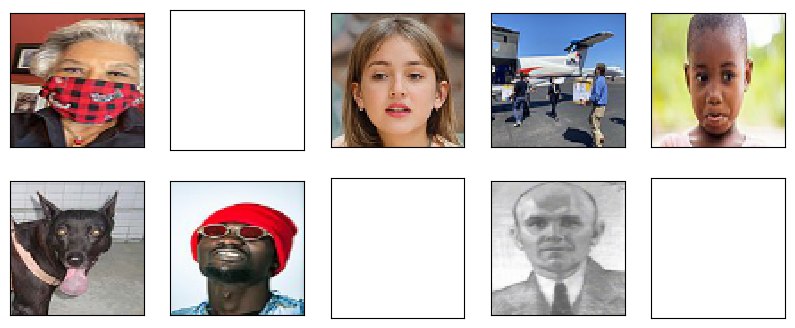

In [ ]:
fig = plt.figure()
fig, ax = plt.subplots(2,5, figsize = (10,4))
for i in range(2):
    for j in range(5):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        if test_result[i*5+j] > 0.5:
            ax[i, j].imshow(test_images[i*5+j],interpolation='nearest')

In [ ]:
from keras.applications.vgg16 import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False,
              input_shape=(75, 75, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

In [ ]:
last_layer = vgg16.get_layer('block4_pool')
last_output = last_layer.output

for layer in vgg16.layers:
   layer.trainable = False

my_layer = layers.Flatten()(last_output)
my_layer = layers.Dense(32, activation='relu')(my_layer)
my_layer = layers.Dense(32, activation='relu')(my_layer)
my_layer = layers.Dense(1, activation='sigmoid')(my_layer)

transfer_learner = Model(vgg16.input, my_layer)

transfer_learner.compile(optimizer='adam',
                         loss='mse',
                         metrics=['accuracy'])

In [ ]:
transfer_learner.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0   

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.4485 - accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 27ms/step - loss: 0.4611 - accuracy: 0.5333
Epoch 3/100
1/1 [==============================] - 0s 27ms/step - loss: 0.4309 - accuracy: 0.5667
Epoch 4/100
1/1 [==============================] - 0s 28ms/step - loss: 0.3447 - accuracy: 0.6000
Epoch 5/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0439 - accuracy: 0.9333
Epoch 6/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0527 - accuracy: 0.9333
Epoch 7/100
1/1 [==============================] - 0s 29ms/step - loss: 4.2271e-04 - accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 11/100
1/1 

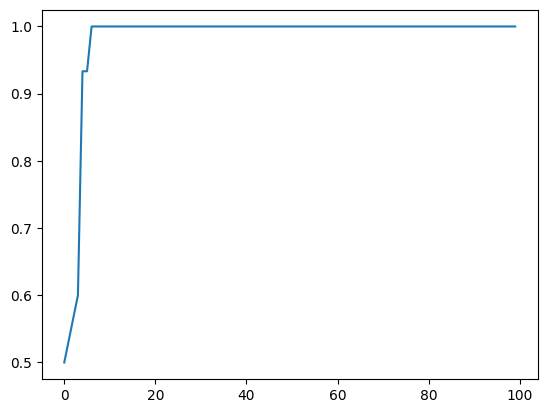

In [ ]:
history = transfer_learner.fit(X, y, epochs=100, shuffle=True)
plt.plot(history.history['accuracy'])

1/1 [==============================] - 0s 498ms/step


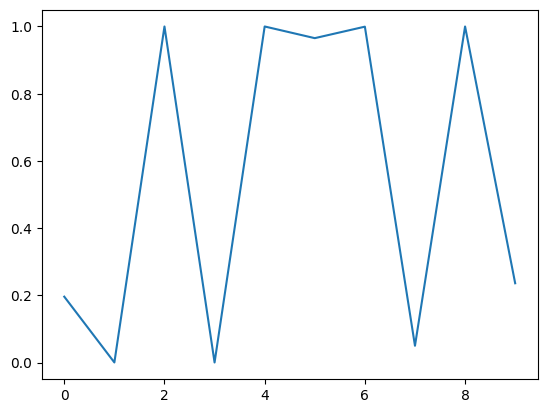

In [ ]:
test_result = transfer_learner.predict(test_images)
plt.plot(test_result)

<Figure size 640x480 with 0 Axes>

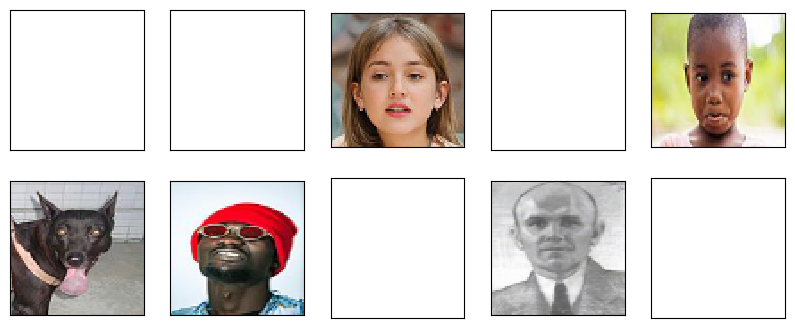

In [ ]:
fig = plt.figure()
fig, ax = plt.subplots(2,5, figsize = (10,4))
for i in range(2):
    for j in range(5):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        if test_result[i*5+j] > 0.5:
            ax[i, j].imshow(test_images[i*5+j],interpolation='nearest')